# IMPORT

In [1]:
# GENERAL
import os
import time 
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PREPROCESSING
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# IMAGE CLASSIFICATION
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.models import model_from_json
# PLOT RESULTS
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# DEFINE FUNCTIONS

In [2]:
def load_GenomicsData(directory, label):
    k = 0                                                                       # TRACK THE NUMBER OF SAMPLES
    file_content_string = ""  
    feature_vector_list = []
    feature_vector = []
    feature_samples_list = []
    os.chdir(directory)                                                         # CHANGE DIRECTORY
    print("Current Working Directory ", os.getcwd())
    print("Extracting data ...")
    for i in os.listdir():                                                      # LIST SUBDIRECTORIES ON 'i' VARIABLE
      if (len(i) == 36):                                                        # LENGHT OF FOLDERS
        os.chdir(path=directory+'/'+i)                                          # CHANGE DIRECTORY
        for j in os.listdir():                                                  # LIST SUBDIRECTORIES ON 'j' VARIABLE
          if (j[-1] == 'z' and j[-2] == 'g' and j[-3] == '.'):                  # SEE IF IS A .gz FILE
            with gzip.open(j, 'r') as f:                                        # OPEN FILE
              file_content = f.read()                                           # READ FILE
              file_content_string += file_content.decode("utf-8")               # DECODE PHASE
              feature_vector_list = file_content_string.split()
              for w in range(0, len(feature_vector_list)):
                if (not (w % 2) and (k == 0)):
                  feature_vector.append(feature_vector_list[w])                 # FEATURE VECTOR
                elif (w % 2):
                  feature_samples_list.append(feature_vector_list[w])           # FEATURE SAMPLES
              k +=1                                                             
              file_content_string = ""
              f.close()                                                         # CLOSE FILE
        os.chdir(directory)                                                     # CHANGE DIRECTORY IN ORDER TO DO THE FOR LOOP
    feature_samples = np.array(feature_samples_list)                            # TO NUMPY ARRAY
    feature_samples_reshape = np.reshape(feature_samples, (-1, 60483))          # RESHAPE FOR DATAFRAME COMPATIBILITY
    dataFrame = pd.DataFrame(data=feature_samples_reshape,                      # MAKE THE DATAFRAME
                                           columns=feature_vector)  
    label_list = list()                                                         # ADD TARGETS IN THE DATAFRAME
    for i in range(0, k):
        label_list.append(label)
    dataFrame['Label'] = np.array(label_list)                                   # ADD LABELS LIST TO DATAFRAME
    print(dataFrame)
    return dataFrame

def load_WSIData(folder):
  image_size = (256,256)                                                        # SET IMAGE SIZE
  batch_size = 32                                                               # SET BATCH SIZE
  test_data = tf.keras.preprocessing.image_dataset_from_directory(
    folder,                                                                     # FOLDER NAME
    image_size=image_size)                                                      # IMAGE SIZE
  return test_data

def one_hot_encoding(dataset):
  enc = LabelBinarizer()
  labels = enc.fit_transform(dataset.class_names)
  labels = to_categorical(labels)
  dataset.class_names = labels

def plot_training_parameter(history):
  ax = plt.subplot(2, 1, 1)
  plt.plot(history.history['binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')
  plt.grid()
  plt.show()
  ax = plt.subplot(2, 1, 2)
  plt.plot(history.history['loss'])
  plt.title('model loss') 
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.grid()
  plt.show()

# CONNECT WITH DRIVE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOAD DATA

In [ ]:
directory_tumoral = "/content/drive/My Drive/Bioinfo/Tumoral/mRNA"              # DIRECTORY TUMORAL
directory_healthy = "/content/drive/My Drive/Bioinfo/Healthy/mRNA"              # DIRECTORY HEALTHY
genomicsData_tumoral = load_GenomicsData(directory_tumoral,'Tumoral')           # DATAFRAME TUMORAL
genomicsData_healthy = load_GenomicsData(directory_healthy,'Healthy')           # DATAFRAME HEALTHY

Current Working Directory  /content/drive/My Drive/Bioinfo/Tumoral/mRNA
Extracting data ...
    ENSG00000242268.2 ENSG00000270112.3  ... ENSG00000181518.3    Label
0                 0.0  0.00332936751564  ...   0.0127996796225  Tumoral
1                 0.0               0.0  ...               0.0  Tumoral
2                 0.0               0.0  ...               0.0  Tumoral
3                 0.0               0.0  ...               0.0  Tumoral
4                 0.0               0.0  ...               0.0  Tumoral
..                ...               ...  ...               ...      ...
636               0.0               0.0  ...               0.0  Tumoral
637               0.0               0.0  ...               0.0  Tumoral
638           45.4830            1.4699  ...            0.0000  Tumoral
639           63.0026            0.9169  ...            0.0000  Tumoral
640               0.0               0.0  ...               0.0  Tumoral

[641 rows x 60484 columns]
Current Working 

In [ ]:
os.chdir("/content/drive/My Drive/Bioinfo/DataSet")                             # CHANGE DIRECTORY
wsiData = load_WSIData('TestSet')                                               # LOAD TEST IMAGES 
print("######## DATA LOADED ##########")

Found 470 files belonging to 2 classes.
######## DATA LOADED ##########


# GENOMICS DATA AND MODEL

## Genomics balance data healthy

In [ ]:
frame = [genomicsData_healthy,genomicsData_tumoral]                             # FRAME OF HEALTHY AND TUMORAL SAMPLES
data = pd.concat(frame)                                                         # CONCATENATE THE FRAME
sm = SMOTE(sampling_strategy='auto')                                            # SMOTE RESAMPLING STRATEGY
features, labels = sm.fit_resample(data.drop('Label',1), data['Label'])         # RESAMPLE FEATURES(X) AND LABEL(Y) FROM DATAFRAME
all_data = pd.DataFrame(features, columns=data.columns[:60483])                 # CONVERT FEATURES ARRAY TO DATAFRAME
all_labels = pd.DataFrame(labels)                                               # CONVERT LABELS ARRAY TO DATAFRAME
all_data['Label'] = all_labels                                                  # CONCATENATE FEATURES AND LABELS
del features, labels, sm , all_labels                                           # FREE MEMORY
print(all_data['Label'].value_counts())                                         # BALANCE COUNT
labels = ['HEALTHY', 'TUMORAL']                                                 # FOR PLOTTING CONVINIENCE LATER ON
print(all_data.head)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Tumoral    641
Healthy    641
Name: Label, dtype: int64
<bound method NDFrame.head of       ENSG00000242268.2  ENSG00000270112.3  ...  ENSG00000181518.3    Label
0              0.000000           0.000000  ...           0.000000  Healthy
1              0.057233           0.000000  ...           0.000000  Healthy
2              0.000000           0.003418  ...           0.000000  Healthy
3              0.030014           0.000000  ...           0.000000  Healthy
4              0.000000           0.000000  ...           0.000000  Healthy
...                 ...                ...  ...                ...      ...
1277           0.000325           0.003312  ...           0.012820  Healthy
1278           0.000000           0.000000  ...           0.000853  Healthy
1279           0.000000           0.004014  ...           0.033944  Healthy
1280           0.013872           0.000000  ...           0.011159  Healthy
1281           0.000000           0.002441  ...           0.012622  Healthy

[

## PCA preprocessing, encode labels and train and test split

In [ ]:
label_encoder = LabelEncoder()
encoded = label_encoder.fit_transform(all_data['Label'])                        # ENCODE THE LABELS COLUMN
X_train, X_test, y_train, y_test = train_test_split(all_data.drop(['Label'],1), # TRAIN AND TEST SPLIT
                                                    encoded,
                                                    test_size=0.366,
                                                    random_state=100)
y_train = pd.DataFrame(y_train)                                                 # LABELS FROM NUMPY TO DATAFRAME
y_test = pd.DataFrame(y_test)                                                   # LABELS FROM NUMPY TO DATAFRAME
X_train = X_train.reset_index(drop=True)                                        # RESET INDEX
y_train = y_train.reset_index(drop=True)                                        # RESET INDEX
X_test = X_test.reset_index(drop=True)                                          # RESET INDEX
y_test = y_test.reset_index(drop=True)                                          # RESET INDEX
x_train = X_train.values                                                        # SELECT TRAIN FEATURES SAMPLES
x_test = X_test.values                                                          # SELECT TEST FEATURES SAMPLES
min_max_scaler = MinMaxScaler()                                                 # SELECT STANDARDIZATION FUNCTION
x_train_scaled = min_max_scaler.fit_transform(x_train)                          # SCALE TRAIN DATA
x_test_scaled = min_max_scaler.transform(x_test)                                # SCALE TEST DATA
pca_3 = PCA(n_components=3)                                                     # SET 3 PCA COMPONENTS
X_train_pca = pca_3.fit_transform(x_train_scaled)                               # FIT_TRANSFORM FOR TRAIN
X_test_pca = pca_3.transform(x_test_scaled)                                     # TRANSFORM FOR TEST
print(X_train_pca.shape)
print(y_train.shape)
print(X_test_pca.shape)
print(y_test.shape)

(812, 3)
(812, 1)
(470, 3)
(470, 1)


## Genomics Model

In [ ]:
def MyModel(input_shape, num_classes, dropout, dense):
    inputs = keras.Input(shape=input_shape)                                     # INPUT LAYER FOR INPUT SHAPE
    x = layers.Dense(dense)(inputs)                                             # DENSE LAYER 512 UNITS
    x = layers.Activation("relu")(x)                                            # RELU ACTIVATION LAYER
    x = layers.Dropout(dropout)(x,training=True)                                # DROPOUT LAYER
    outputs = layers.Dense(1, activation='sigmoid')(x)                          # FINAL DENSE LAYER
    return keras.Model(inputs, outputs)


My_Genomics_model_4 = MyModel(input_shape=(3), num_classes=2,dropout=0.1,       # BUILD THE MODEL
                            dense=4)                  
My_Genomics_model_4.summary()

My_Genomics_model_8 = MyModel(input_shape=(3), num_classes=2,dropout=0.1,       # BUILD THE MODEL
                            dense=8)                  
My_Genomics_model_8.summary()

My_Genomics_model_16 = MyModel(input_shape=(3), num_classes=2,dropout=0.1,      # BUILD THE MODEL
                            dense=16)                  
My_Genomics_model_16.summary()

My_Genomics_model_64 = MyModel(input_shape=(3), num_classes=2,dropout=0.1,      # BUILD THE MODEL
                            dense=64)                  
My_Genomics_model_64.summary()

My_Genomics_model_128 = MyModel(input_shape=(3), num_classes=2,dropout=0.1,     # BUILD THE MODEL
                            dense=128)                  
My_Genomics_model_128.summary()


Model: "functional_309"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_155 (InputLayer)       [(None, 3)]               0         
_________________________________________________________________
dense_308 (Dense)            (None, 4)                 16        
_________________________________________________________________
activation_154 (Activation)  (None, 4)                 0         
_________________________________________________________________
dropout_159 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_309 (Dense)            (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Model: "functional_311"
_________________________________________________________________
Layer (type)                 Out

## Fit and Evaluate Genomics Model

In [ ]:
My_Genomics_model_4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),                        # BINARY ACCURACY
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])                         
My_Genomics_model_4_history = My_Genomics_model_4.fit(X_train_pca,              # FIT THE MODEL
                               y_train,
                               epochs=60)     

Epoch 1/60
26/26 [==============================] - 0s 1ms/step - loss: 0.7646 - binary_accuracy: 0.3153 - false_positives_105: 332.0000 - false_negatives_105: 224.0000 - true_positives_105: 181.0000 - true_negatives_105: 75.0000 - precision_105: 0.3528 - recall_105: 0.4469
Epoch 2/60
26/26 [==============================] - 0s 1ms/step - loss: 0.7594 - binary_accuracy: 0.3239 - false_positives_105: 331.0000 - false_negatives_105: 218.0000 - true_positives_105: 187.0000 - true_negatives_105: 76.0000 - precision_105: 0.3610 - recall_105: 0.4617
Epoch 3/60
26/26 [==============================] - 0s 1ms/step - loss: 0.7579 - binary_accuracy: 0.3190 - false_positives_105: 342.0000 - false_negatives_105: 211.0000 - true_positives_105: 194.0000 - true_negatives_105: 65.0000 - precision_105: 0.3619 - recall_105: 0.4790
Epoch 4/60
26/26 [==============================] - 0s 1ms/step - loss: 0.7584 - binary_accuracy: 0.3005 - false_positives_105: 345.0000 - false_negatives_105: 223.0000 - true

In [ ]:
My_Genomics_model_8.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),                        # BINARY ACCURACY
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])                         
My_Genomics_model_8_history = My_Genomics_model_8.fit(X_train_pca,              # FIT THE MODEL
                               y_train,
                               epochs=50)     

Epoch 1/50
26/26 [==============================] - 0s 1ms/step - loss: 0.8713 - binary_accuracy: 0.2007 - false_positives_106: 394.0000 - false_negatives_106: 255.0000 - true_positives_106: 150.0000 - true_negatives_106: 13.0000 - precision_106: 0.2757 - recall_106: 0.3704
Epoch 2/50
26/26 [==============================] - 0s 1ms/step - loss: 0.8711 - binary_accuracy: 0.1897 - false_positives_106: 398.0000 - false_negatives_106: 260.0000 - true_positives_106: 145.0000 - true_negatives_106: 9.0000 - precision_106: 0.2670 - recall_106: 0.3580
Epoch 3/50
26/26 [==============================] - 0s 1ms/step - loss: 0.8703 - binary_accuracy: 0.1921 - false_positives_106: 394.0000 - false_negatives_106: 262.0000 - true_positives_106: 143.0000 - true_negatives_106: 13.0000 - precision_106: 0.2663 - recall_106: 0.3531
Epoch 4/50
26/26 [==============================] - 0s 1ms/step - loss: 0.8607 - binary_accuracy: 0.2204 - false_positives_106: 394.0000 - false_negatives_106: 239.0000 - true_

In [ ]:
My_Genomics_model_16.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),                        # BINARY ACCURACY
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])                         
My_Genomics_model_16_history = My_Genomics_model_16.fit(X_train_pca,            # FIT THE MODEL
                               y_train,
                               epochs=40)     

Epoch 1/40
26/26 [==============================] - 0s 1ms/step - loss: 0.8555 - binary_accuracy: 0.2931 - false_positives_107: 404.0000 - false_negatives_107: 170.0000 - true_positives_107: 235.0000 - true_negatives_107: 3.0000 - precision_107: 0.3678 - recall_107: 0.5802
Epoch 2/40
26/26 [==============================] - 0s 1ms/step - loss: 0.8538 - binary_accuracy: 0.2980 - false_positives_107: 402.0000 - false_negatives_107: 168.0000 - true_positives_107: 237.0000 - true_negatives_107: 5.0000 - precision_107: 0.3709 - recall_107: 0.5852
Epoch 3/40
26/26 [==============================] - 0s 1ms/step - loss: 0.8463 - binary_accuracy: 0.3202 - false_positives_107: 403.0000 - false_negatives_107: 149.0000 - true_positives_107: 256.0000 - true_negatives_107: 4.0000 - precision_107: 0.3885 - recall_107: 0.6321
Epoch 4/40
26/26 [==============================] - 0s 1ms/step - loss: 0.8407 - binary_accuracy: 0.3461 - false_positives_107: 400.0000 - false_negatives_107: 131.0000 - true_po

In [ ]:
My_Genomics_model_64.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),                        # BINARY ACCURACY
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])                         
My_Genomics_model_64_history = My_Genomics_model_64.fit(X_train_pca,            # FIT THE MODEL
                               y_train,
                               epochs=20)     

Epoch 1/20
26/26 [==============================] - 0s 1ms/step - loss: 0.6743 - binary_accuracy: 0.7254 - false_positives_108: 38.0000 - false_negatives_108: 185.0000 - true_positives_108: 220.0000 - true_negatives_108: 369.0000 - precision_108: 0.8527 - recall_108: 0.5432
Epoch 2/20
26/26 [==============================] - 0s 1ms/step - loss: 0.6558 - binary_accuracy: 0.7759 - false_positives_108: 29.0000 - false_negatives_108: 153.0000 - true_positives_108: 252.0000 - true_negatives_108: 378.0000 - precision_108: 0.8968 - recall_108: 0.6222
Epoch 3/20
26/26 [==============================] - 0s 1ms/step - loss: 0.6469 - binary_accuracy: 0.7845 - false_positives_108: 27.0000 - false_negatives_108: 148.0000 - true_positives_108: 257.0000 - true_negatives_108: 380.0000 - precision_108: 0.9049 - recall_108: 0.6346
Epoch 4/20
26/26 [==============================] - 0s 1ms/step - loss: 0.6300 - binary_accuracy: 0.8227 - false_positives_108: 17.0000 - false_negatives_108: 127.0000 - true_

In [ ]:
My_Genomics_model_128.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),                        # BINARY ACCURACY
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])                         
My_Genomics_model_128_history = My_Genomics_model_128.fit(X_train_pca,          # FIT THE MODEL
                               y_train,
                               epochs=10)     


Epoch 1/10
26/26 [==============================] - 0s 1ms/step - loss: 0.7307 - binary_accuracy: 0.5259 - false_positives_109: 274.0000 - false_negatives_109: 111.0000 - true_positives_109: 294.0000 - true_negatives_109: 133.0000 - precision_109: 0.5176 - recall_109: 0.7259
Epoch 2/10
26/26 [==============================] - 0s 1ms/step - loss: 0.7001 - binary_accuracy: 0.6970 - false_positives_109: 172.0000 - false_negatives_109: 74.0000 - true_positives_109: 331.0000 - true_negatives_109: 235.0000 - precision_109: 0.6581 - recall_109: 0.8173
Epoch 3/10
26/26 [==============================] - 0s 1ms/step - loss: 0.6697 - binary_accuracy: 0.8177 - false_positives_109: 86.0000 - false_negatives_109: 62.0000 - true_positives_109: 343.0000 - true_negatives_109: 321.0000 - precision_109: 0.7995 - recall_109: 0.8469
Epoch 4/10
26/26 [==============================] - 0s 1ms/step - loss: 0.6467 - binary_accuracy: 0.8732 - false_positives_109: 57.0000 - false_negatives_109: 46.0000 - true_p

In [ ]:
print("Evaluate on test data")
results = My_Genomics_model_4.evaluate(X_test_pca,y_test, batch_size=128)       # EVALUATE THE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])           
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])
print("Evaluate on test data")
results = My_Genomics_model_8.evaluate(X_test_pca,y_test, batch_size=128)       # EVALUATE THE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])           
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])
print("Evaluate on test data")
results = My_Genomics_model_16.evaluate(X_test_pca,y_test, batch_size=128)      # EVALUATE THE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])           
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])
print("Evaluate on test data")
results = My_Genomics_model_64.evaluate(X_test_pca,y_test, batch_size=128)      # EVALUATE THE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])           
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])
print("Evaluate on test data")
results = My_Genomics_model_128.evaluate(X_test_pca,y_test, batch_size=128)     # EVALUATE THE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])           
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

Evaluate on test data
4/4 [==============================] - 0s 2ms/step - loss: 0.6588 - binary_accuracy: 0.8362 - false_positives_105: 17.0000 - false_negatives_105: 60.0000 - true_positives_105: 176.0000 - true_negatives_105: 217.0000 - precision_105: 0.9119 - recall_105: 0.7458
Loss:            0.6587974429130554 
Accuracy:        0.8361701965332031
False Positive:  17.0 
False Negative:  60.0
True Positive:   176.0 
True Negative:   217.0
Precision    :   0.9119170904159546 
Recall:          0.7457627058029175
Evaluate on test data
4/4 [==============================] - 0s 2ms/step - loss: 0.6182 - binary_accuracy: 0.8298 - false_positives_106: 34.0000 - false_negatives_106: 46.0000 - true_positives_106: 190.0000 - true_negatives_106: 200.0000 - precision_106: 0.8482 - recall_106: 0.8051
Loss:            0.6181778907775879 
Accuracy:        0.8297872543334961
False Positive:  34.0 
False Negative:  46.0
True Positive:   190.0 
True Negative:   200.0
Precision    :   0.848214268684

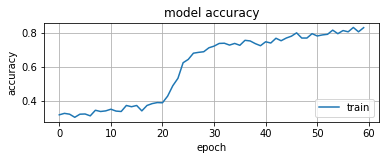

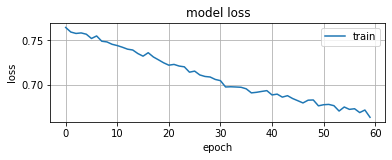

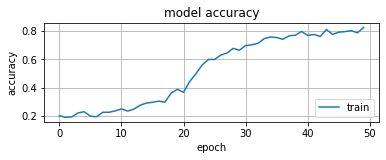

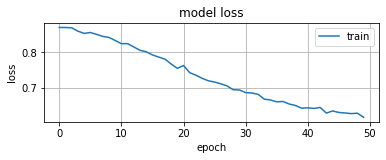

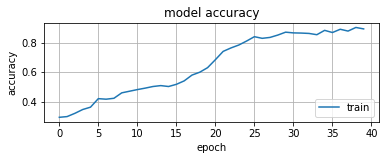

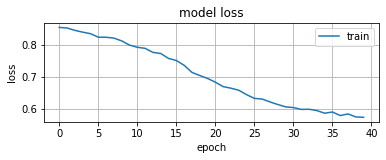

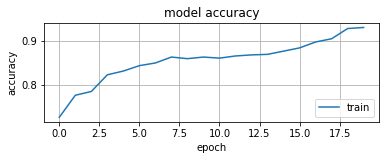

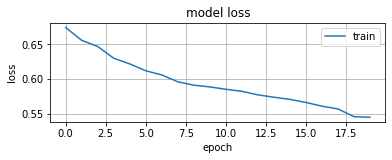

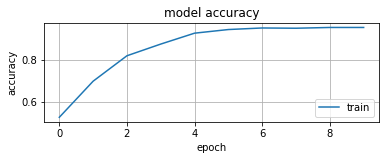

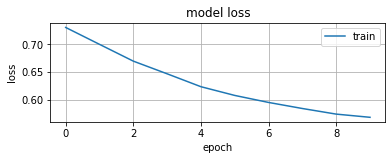

In [ ]:
plot_training_parameter(My_Genomics_model_4_history)
plot_training_parameter(My_Genomics_model_8_history)
plot_training_parameter(My_Genomics_model_16_history)
plot_training_parameter(My_Genomics_model_64_history)
plot_training_parameter(My_Genomics_model_128_history)

In [ ]:
pred_labels = My_Genomics_model_4.predict(X_test_pca)
cm = confusion_matrix(y_test, pred_labels.round())
print("Confusion Matrix")
print(cm)
pred_labels = My_Genomics_model_8.predict(X_test_pca)
cm = confusion_matrix(y_test, pred_labels.round())
print("Confusion Matrix")
print(cm)
pred_labels = My_Genomics_model_16.predict(X_test_pca)
cm = confusion_matrix(y_test, pred_labels.round())
print("Confusion Matrix")
print(cm)
pred_labels = My_Genomics_model_64.predict(X_test_pca)
cm = confusion_matrix(y_test, pred_labels.round())
print("Confusion Matrix")
print(cm)
pred_labels = My_Genomics_model_128.predict(X_test_pca)
cm = confusion_matrix(y_test, pred_labels.round())
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[222  12]
 [ 58 178]]
Confusion Matrix
[[198  36]
 [ 40 196]]
Confusion Matrix
[[208  26]
 [ 20 216]]
Confusion Matrix
[[234   0]
 [ 25 211]]
Confusion Matrix
[[234   0]
 [ 13 223]]


## Save Model

In [ ]:
os.chdir('/content/drive/MyDrive/Bioinfo')                                      # CHANGE DIRECTORY
model_name = 'My_Genomics_model_clf2_2048_drop01_lr1e-3_acc97'                  # MODEL NAME  
My_model_json = My_Genomics_model.to_json()                                     # CONVERT TO JSON FILE  
with open(str(model_name)+'.json', "w") as json_file:                           # WRITE JSON FILE
    json_file.write(My_model_json)
My_Genomics_model.save_weights(str(model_name)+'.h5')                           # SAVE WEIGHTS
print("Saved model to disk")

Saved model to disk


## Load the best model

In [ ]:
os.chdir('/content/drive/My Drive/Bioinfo')                                     # CHANGE DIRECTORY
model_name = 'My_Genomics_model_clf2_2048_drop01_lr1e-3_acc97'                  # MODEL NAME
json_file = open(str(model_name)+'.json', 'r')                                  # OPEN JSON FILE
loaded_model_json = json_file.read()
json_file.close()
My_Genomics_model = model_from_json(loaded_model_json)                          # LOAD JSON FILE
My_Genomics_model.load_weights(str(model_name)+'.h5')                           # LOAD WEIGHTS
print("Loaded model from disk")
My_Genomics_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),   # ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])   
print("Evaluate on test data")
results = My_Genomics_model.evaluate(X_test_pca,y_test, batch_size=1,verbose=2) # EVALUATE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])        

Loaded model from disk
Evaluate on test data
470/470 - 1s - loss: 0.5107 - binary_accuracy: 0.9787 - false_positives_4: 0.0000e+00 - false_negatives_4: 10.0000 - true_positives_4: 226.0000 - true_negatives_4: 234.0000 - precision_4: 1.0000 - recall_4: 0.9576
Loss:            0.5106649398803711 
Accuracy:        0.978723406791687
False Positive:  0.0 
False Negative:  10.0
True Positive:   226.0 
True Negative:   234.0
Precision    :   1.0 
Recall:          0.9576271176338196


# IMAGE DATA AND MODEL

## Features and Labels split & Label Encoding

In [ ]:
os.chdir('/content/drive/My Drive/Bioinfo/DataSet')                             # CHANGE DIRECTORY
one_hot_encoding(wsiData)                                                       # ONE HOT ENCODING TEST DATA
labels = np.concatenate([y for x, y in wsiData])                                # EXTRACT LABELS
images = np.concatenate([x for x, y in wsiData])                                # EXTRACT IMAGES
print(labels)
print(images.shape)

[1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1
 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1
 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1
 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1
 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1
 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0
 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0
 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1
 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0
 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1]
(470, 256, 256, 3)


In [ ]:
print(len(labels))
print(images.shape)

470
(470, 256, 256, 3)


## Load models

In [ ]:
os.chdir('/content/drive/My Drive/Bioinfo/DataSet')                             # CHANGE DIRECTORY
model_name_1 = 'My_model_clf0_drop01_lr1e-4'                                    # MODEL NAME
json_file = open(str(model_name_1)+'.json', 'r')                                # OPEN JSON FILE
loaded_model_json_1 = json_file.read()                                                
json_file.close()
My_Images_model_1 = model_from_json(loaded_model_json_1)                        # LOAD JSON
My_Images_model_1.load_weights(str(model_name_1)+'.h5')                         # LOAD WEIGHTS
print("Loaded model from disk")
model_name_2 = 'My_model_clf1_2048_alldrop_01_lr1e-4'                           # MODEL NAME
json_file = open(str(model_name_2)+'.json', 'r')                                # OPEN JSON FILE
loaded_model_json_2 = json_file.read()                                                
json_file.close()
My_Images_model_2 = model_from_json(loaded_model_json_2)                        # LOAD JSON
My_Images_model_2.load_weights(str(model_name_2)+'.h5')                         # LOAD WEIGHTS
print("Loaded model from disk")
model_name_3 = 'My_model_clf2_1024_alldrop_01_lr1e-4'                           # MODEL NAME
json_file = open(str(model_name_3)+'.json', 'r')                                # OPEN JSON FILE
loaded_model_json_3 = json_file.read()                                                
json_file.close()
My_Images_model_3 = model_from_json(loaded_model_json_3)                        # LOAD JSON
My_Images_model_3.load_weights(str(model_name_3)+'.h5')                         # LOAD WEIGHTS
print("Loaded model from disk")
      

Loaded model from disk
Loaded model from disk
Loaded model from disk


## Evaluate models

In [ ]:
My_Images_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])   
print("Evaluate on test data")
results = My_Images_model_1.evaluate(wsiData, batch_size=1,verbose=2)           # EVALUATE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])  
My_Images_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])   
print("Evaluate on test data")
results = My_Images_model_2.evaluate(wsiData, batch_size=1,verbose=2)           # EVALUATE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])  
My_Images_model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),# ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])   
print("Evaluate on test data")
results = My_Images_model_3.evaluate(wsiData, batch_size=1,verbose=2)           # EVALUATE MODEL
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])  

Evaluate on test data
15/15 - 3s - loss: 0.5716 - binary_accuracy: 0.8298 - false_positives: 8.0000 - false_negatives: 72.0000 - true_positives: 163.0000 - true_negatives: 227.0000 - precision: 0.9532 - recall: 0.6936
Loss:            0.5716420412063599 
Accuracy:        0.8297872543334961
False Positive:  8.0 
False Negative:  72.0
True Positive:   163.0 
True Negative:   227.0
Precision    :   0.9532163739204407 
Recall:          0.693617045879364
Evaluate on test data
15/15 - 4s - loss: 0.5715 - binary_accuracy: 0.8340 - false_positives_1: 10.0000 - false_negatives_1: 68.0000 - true_positives_1: 167.0000 - true_negatives_1: 225.0000 - precision_1: 0.9435 - recall_1: 0.7106
Loss:            0.5715011358261108 
Accuracy:        0.8340425491333008
False Positive:  10.0 
False Negative:  68.0
True Positive:   167.0 
True Negative:   225.0
Precision    :   0.9435028433799744 
Recall:          0.7106382846832275
Evaluate on test data
15/15 - 2s - loss: 0.6237 - binary_accuracy: 0.7681 - f

TRY PREDICT BUT IT DOESN'T WORK AS EVALUATE

In [ ]:
pred_labels = My_Images_model_1.predict(wsiData)
predDataframe = pd.DataFrame(pred_labels,columns=['Predictions'])
predDataframe['True Labels'] = labels
print(predDataframe)
predDataframe.loc[(predDataframe['Predictions'] > 0.5), 'Predictions'] = 1
predDataframe.loc[(predDataframe['Predictions'] < 0.5), 'Predictions'] = 0
k=0
for i,j in zip(predDataframe['Predictions'].values,predDataframe['True Labels'].values):
  if (i==j):
    k+=1
predAccuracy = k/int(len(predDataframe['Predictions'].values))
print('Accuracy: ',predAccuracy)

      Predictions  True Labels
0    1.000000e+00            1
1    2.723995e-08            1
2    9.027992e-09            0
3    1.174431e-08            1
4    1.000000e+00            0
..            ...          ...
465  6.535935e-06            0
466  1.000000e+00            1
467  8.218757e-07            0
468  1.000000e+00            0
469  5.390601e-07            1

[470 rows x 2 columns]
Accuracy:  0.4829787234042553


In [ ]:
pred_labels = My_Images_model_1.predict(wsiData)
cm = confusion_matrix(labels, pred_labels.round())
print("Confusion Matrix")
print(cm)
pred_labels = My_Images_model_2.predict(wsiData)
cm = confusion_matrix(labels, pred_labels.round())
print("Confusion Matrix")
print(cm)
pred_labels = My_Images_model_3.predict(wsiData)
cm = confusion_matrix(labels, pred_labels.round())
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[153  82]
 [146  89]]
Confusion Matrix
[[152  83]
 [139  96]]
Confusion Matrix
[[ 99 136]
 [104 131]]


# CONSENSUS CLASSIFIER

## IMAGES

### Analysis

In [ ]:
image_preds_healthy=[]                                                          # HEALTHY PREDICTIONS                                      
image_preds_tumoral=[]                                                          # TUMORAL PREDICTION
image_uncertainty_healthy=[]                                                    # HEALTHY UNCERTAINTY
image_uncertainty_tumoral=[]                                                    # TUMORAL UNCERTAINTY
for image , label in zip(images,labels):                                          
  if (label==0):                                                                # IF HEALTHY
    image_pred_healthy = []                                                     # PREDICTIONS AMONG THE SAME INPUT
    image = np.asarray(image).reshape((1,256,256,3))                            # CONTERT TO NUMPY ARRAY AND RESHAPE FOR INPUT LAYER
    for i in range(0,10):                                                       # 10 PREDICTIONS
      _image_pred_healthy = My_Images_model_1.predict(image)                    # PREDICT
      image_pred_healthy.append(float(_image_pred_healthy))                     # APPEND PREDICTION TO A LIST  
      _image_pred_healthy = My_Images_model_2.predict(image)                    # PREDICT
      image_pred_healthy.append(float(_image_pred_healthy))                     # APPEND PREDICTION TO A LIST  
      _image_pred_healthy = My_Images_model_3.predict(image)                    # PREDICT
      image_pred_healthy.append(float(_image_pred_healthy))                     # APPEND PREDICTION TO A LIST    
    image_pred_healthy = np.array(image_pred_healthy)                           # CONVERT LIST TO NUMPY ARRAY
    mean_image_pred_healthy = np.mean(image_pred_healthy, axis=0)               # CALCULATE THE MEAN
    if (np.mean(image_pred_healthy, axis=0)<0.5):
      mean_image_pred_healthy = np.mean(image_pred_healthy, axis=0)-1           # -> -1 HEALTHY
    else:
      mean_image_pred_healthy = np.mean(image_pred_healthy, axis=0)             # -> 1 TUMORAL
    image_preds_healthy.append(mean_image_pred_healthy)                         # APPEND PREDICTION MEAN
    aleatoric = np.mean(image_pred_healthy * (1 - image_pred_healthy), axis=0)  # CALCULATE UNCERTAINTIES
    epistemic = np.mean(image_pred_healthy ** 2, axis=0) - np.mean(image_pred_healthy, axis=0) ** 2
    uncertainty_image_pred_healthy = epistemic + aleatoric                      # SUM UNCERTAINTIES
    image_uncertainty_healthy.append(uncertainty_image_pred_healthy)            # APPEND PREDICTION UNCERTAINTY
  if (label==1):                                                                # IF TUMORAL
    image_pred_tumoral = []                                                     # PREDICTIONS AMONG THE SAME INPUT
    image = np.asarray(image).reshape((1,256,256,3))                            # CONTERT TO NUMPY ARRAY AND RESHAPE FOR INPUT LAYER
    for i in range(0,10):                                                       # 10 PREDICTIONS
      _image_pred_tumoral = My_Images_model_1.predict(image)                    # PREDICT
      image_pred_tumoral.append(float(_image_pred_tumoral))                     # APPEND PREDICTION TO A LIST   
      _image_pred_tumoral = My_Images_model_2.predict(image)                    # PREDICT
      image_pred_tumoral.append(float(_image_pred_tumoral))                     # APPEND PREDICTION TO A LIST   
      _image_pred_tumoral = My_Images_model_3.predict(image)                    # PREDICT
      image_pred_tumoral.append(float(_image_pred_tumoral))                     # APPEND PREDICTION TO A LIST    
    image_pred_tumoral = np.array(image_pred_tumoral)                           # CONVERT LIST TO NUMPY ARRAY
    mean_image_pred_tumoral = np.mean(image_pred_tumoral, axis=0)               # CALCULATE THE MEAN
    if (np.mean(image_pred_tumoral, axis=0)<0.5):
      mean_image_pred_tumoral = np.mean(image_pred_tumoral, axis=0)-1           # -> -1 HEALTHY
    else:
      mean_image_pred_tumoral = np.mean(image_pred_tumoral, axis=0)             # -> 1 TUMORAL
    image_preds_tumoral.append(mean_image_pred_tumoral)                         # APPEND PREDICTION MEAN
    aleatoric = np.mean(image_pred_tumoral * (1 - image_pred_tumoral), axis=0)  # CALCULATE UNCERTAINTIES
    epistemic = np.mean(image_pred_tumoral ** 2, axis=0) - np.mean(image_pred_tumoral, axis=0) ** 2
    uncertainty_image_pred_tumoral = epistemic + aleatoric                      # SUM UNCERTAINTIES
    image_uncertainty_tumoral.append(uncertainty_image_pred_tumoral)            # APPEND PREDICTION UNCERTAINTY

### Results Analysis

In [ ]:
genomicsDataframe = pd.read_csv('/content/drive/My Drive/Bioinfo/imageDataFrame.csv')

In [ ]:
imageDataframe = pd.DataFrame(image_preds_healthy,columns=['Healthy Predictions'])
imageDataframe['Healthy Uncertainty'] = image_uncertainty_healthy
imageDataframe['Tumoral Predictions'] = image_preds_tumoral[:len(image_preds_healthy)]
imageDataframe['Tumoral Uncertainty'] = image_uncertainty_tumoral[:len(image_preds_healthy)]

In [ ]:
k=0
for i,j in zip(imageDataframe['Healthy Predictions'].values,imageDataframe['Healthy Uncertainty'].values):
  if (i<0):
    k+=1
print('Accuracy Healthy: ',k/int(len(imageDataframe['Healthy Predictions'].values)))
w=0
for i,j in zip(imageDataframe['Tumoral Predictions'].values,imageDataframe['Tumoral Uncertainty'].values):
  if (i>0):
    w+=1
print('Accuracy Tumoral: ',w/int(len(imageDataframe['Tumoral Predictions'].values)))

Accuracy Healthy:  0.6170212765957447
Accuracy Tumoral:  0.37872340425531914


In [ ]:
imageDataframe.to_csv('/content/drive/My Drive/Bioinfo/imageDataFrame.csv',index=True)

### Reverse label based on uncertainty

In [ ]:
# HEALTHY
sigma = 0.21
imageDataframe.loc[(imageDataframe['Healthy Uncertainty'] > sigma), 'Healthy Predictions'] = -1*imageDataframe['Healthy Predictions']
k=0
for i,j in zip(imageDataframe['Healthy Predictions'].values,imageDataframe['Healthy Uncertainty'].values):
  if (i<0):
    k+=1
imagesAccuracyHealthy = k/int(len(imageDataframe['Healthy Predictions'].values))
print('Accuracy Healthy: ',imagesAccuracyHealthy)

Accuracy Healthy:  0.46808510638297873


In [ ]:
# TUMORAL
imageDataframe.loc[(imageDataframe['Tumoral Uncertainty'] > sigma), 'Tumoral Predictions'] = -1*imageDataframe['Tumoral Predictions']
w=0
for i,j in zip(imageDataframe['Tumoral Predictions'].values,imageDataframe['Tumoral Uncertainty'].values):
  if (i>0):
    w+=1
imagesAccuracyTumoral = w/int(len(imageDataframe['Tumoral Predictions'].values))
print('Accuracy Tumoral: ', imagesAccuracyTumoral)

Accuracy Tumoral:  0.4978723404255319


In [ ]:
imageDataframe.to_csv('/content/drive/My Drive/Bioinfo/reverseImageDataFrame.csv',index=True)

### Uncertainty

HEALTHY

In [ ]:
max_uncertainty_correct = 0
min_uncertainty_incorrect = 1
for i,j in zip(imageDataframe['Healthy Predictions'].values,imageDataframe['Healthy Uncertainty'].values):
  if (i<0):                                                                     # CORRECT PREDICTION
    if (j>max_uncertainty_correct):                                             # NEW MAX UNCERTAINTY ON CORRECT PREDICTION
      max_uncertainty_correct = j
  else:                                                                         # WRONG PREDICTION
    if (j<min_uncertainty_incorrect):                                           # NEW MIN UNCERTAINTY ON WRONG PREDICTION
      min_uncertainty_incorrect = j
print('Max Uncertainty on correct predictions: ',max_uncertainty_correct,
      '\nMin Uncertainty on wrong predictions :  ',min_uncertainty_incorrect)

sigma = 0.21

k=0
w=0
z=0
q=0
for i,j in zip(imageDataframe['Healthy Predictions'].values,imageDataframe['Healthy Uncertainty'].values):
  if (i<0):                                                                     # CORRECT PREDICTION
    if (j<sigma):                                                               # UNCERTAIN CORRECT PREDICTION LESS THEN SIGMA
      k+=1                                                                      # SURE CORRECT PREDICTIONS
    else:
      z+=1                                                                      # NOT SURE CORRECT PREDICTIONS
  else:
    if (j<sigma):                                                               # UNCERTAIN WRONG PREDICTION LESS THEN SIGMA
      w+=1                                                                      # SURE WRONG PREDICTIONS
    else:
      q+=1                                                                      # NOT SURE WRONG PREDICTIONS
k=k/int(len(imageDataframe['Healthy Predictions'].values))
w=w/int(len(imageDataframe['Healthy Predictions'].values))
z=z/int(len(imageDataframe['Healthy Predictions'].values))
q=q/int(len(imageDataframe['Healthy Predictions'].values))
print('\nReverse label prediction with sigma = ',sigma,'\n')
print('Correct Sure Prediction:     ',k,'% ',' Wrong Sure Prediction:       ',w,'%\n')
print('Correct Not Sure Prediction: ',z,'% ',' Wrong Not Sure Prediction:   ',q,'%\n')

Max Uncertainty on correct predictions:  0.24998232858871486 
Min Uncertainty on wrong predictions :   0.0

Reverse label prediction with sigma =  0.21 

Correct Sure Prediction:      0.43829787234042555 %   Wrong Sure Prediction:        0.35319148936170214 %

Correct Not Sure Prediction:  0.029787234042553193 %   Wrong Not Sure Prediction:    0.17872340425531916 %



TUMORAL

In [ ]:
max_uncertainty_correct = 0
min_uncertainty_incorrect = 1
for i,j in zip(imageDataframe['Tumoral Predictions'].values,imageDataframe['Tumoral Uncertainty'].values):
  if (i>0):                                                                     # CORRECT PREDICTION
    if (j>max_uncertainty_correct):                                             # NEW MAX UNCERTAINTY ON CORRECT PREDICTIONS
      max_uncertainty_correct = j
  else:                                                                         # WRONG PREDICTION
    if (j<min_uncertainty_incorrect):                                           # NEW MIN UNCERTAINTY ON WRONG PREDICTION
      min_uncertainty_incorrect = j
print('Max Uncertainty on correct predictions: ',max_uncertainty_correct,
      ' Min Uncertainty on wrong predictions :  ',min_uncertainty_incorrect)

sigma = 0.21
k=0
w=0
z=0
q=0
for i,j in zip(imageDataframe['Tumoral Predictions'].values,imageDataframe['Tumoral Uncertainty'].values):
  if (i>0):                                                                     # CORRECT PREDICTION
    if (j<sigma):                                                               # UNCERTAIN CORRECT PREDICTION LESS THEN SIGMA
      k+=1                                                                      # SURE CORRECT PREDICTIONS
    else:
      z+=1                                                                      # NOT SURE CORRECT PREDICTIONS
  else:
    if (j<sigma):                                                               # UNCERTAIN WRONG PREDICTION LESS THEN SIGMA
      w+=1                                                                      # SURE WRONG PREDICTIONS
    else:
      q+=1                                                                      # NOT SURE WRONG PREDICTIONS
k=k/int(len(imageDataframe['Tumoral Predictions'].values))
w=w/int(len(imageDataframe['Tumoral Predictions'].values))
z=z/int(len(imageDataframe['Tumoral Predictions'].values))
q=q/int(len(imageDataframe['Tumoral Predictions'].values))
print('\nReverse label prediction with sigma = ',sigma,'\n')
print('Correct Sure Prediction:     ',k,'% ',' Wrong Sure Prediction:       ',w,'%\n')
print('Correct Not Sure Prediction: ',z,'% ',' Wrong Not Sure Prediction:   ',q,'%\n')

Max Uncertainty on correct predictions:  0.2493724750858355  Min Uncertainty on wrong predictions :   1.887377114438724e-10

Reverse label prediction with sigma =  0.21 

Correct Sure Prediction:      0.3617021276595745 %   Wrong Sure Prediction:        0.4851063829787234 %

Correct Not Sure Prediction:  0.13617021276595745 %   Wrong Not Sure Prediction:    0.01702127659574468 %



## GENOMICS

### Analysis

In [ ]:
# FOR COMPATIBILITY IN ZIP LOOP
y_test_=y_test.to_numpy()
y_test_=y_test_.tolist()
_y_test = [item for sub in y_test_ for item in sub]

In [ ]:
genomic_preds_healthy=[]                                                        # HEALTHY PREDICTIONS
genomic_preds_tumoral=[]                                                        # TUMORAL PREDICTIONS
genomic_uncertainty_healthy=[]                                                  # HEALTHY UNCERTAINTY
genomic_uncertainty_tumoral=[]                                                  # TUMORAL UNCERTAINTY
for genomic, label in zip(X_test_pca,_y_test):                          
  if (label==0):                                                                # IF HEALTHY
    genomic_pred_healthy = []                                                   # PREDICTION LIST
    genomic = np.asarray(genomic).reshape((1,3))                                # CONTERT TO NUMPY ARRAY AND RESHAPE FOR INPUT LAYER
    for i in range(0,10):                                                       # NUMBER OF PREDICTIONS
      _genomic_pred_healthy = My_Genomics_model_4.predict(genomic)              # PREDICT
      genomic_pred_healthy.append(float(_genomic_pred_healthy))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_healthy = My_Genomics_model_8.predict(genomic)              # PREDICT
      genomic_pred_healthy.append(float(_genomic_pred_healthy))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_healthy = My_Genomics_model_16.predict(genomic)             # PREDICT
      genomic_pred_healthy.append(float(_genomic_pred_healthy))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_healthy = My_Genomics_model_64.predict(genomic)             # PREDICT
      genomic_pred_healthy.append(float(_genomic_pred_healthy))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_healthy = My_Genomics_model_128.predict(genomic)            # PREDICT
      genomic_pred_healthy.append(float(_genomic_pred_healthy))                 # APPEND PREDICTIONS TO A LIST
    genomic_pred_healthy = np.array(genomic_pred_healthy)                       # LIST TO NUMPY ARRAY
    if (np.mean(genomic_pred_healthy, axis=0)<0.5):
      mean_genomic_pred_healthy = np.mean(genomic_pred_healthy, axis=0)-1       # -> -1 HEALTHY
    else:
      mean_genomic_pred_healthy = np.mean(genomic_pred_healthy, axis=0)         # ->1 TUMORAL
    genomic_preds_healthy.append(mean_genomic_pred_healthy)                     # APPEND PREDICTIONS MEAN
    aleatoric = np.mean(genomic_pred_healthy * (1 - genomic_pred_healthy), axis=0)  
    epistemic = np.mean(genomic_pred_healthy ** 2, axis=0) - np.mean(genomic_pred_healthy, axis=0) ** 2
    uncertainty_genomic_pred_healthy = epistemic + aleatoric                    # ADD UNCERTAINTIES
    genomic_uncertainty_healthy.append(uncertainty_genomic_pred_healthy)        # APPEND PREDICTIONS UNCERTAINTY
  if (label==1):                                                                # IF TUMORAL
    genomic_pred_tumoral = []                                                   # PREDICTIONS LIST
    genomic = np.asarray(genomic).reshape((1,3))                                # CONTERT TO NUMPY ARRAY AND RESHAPE FOR INPUT LAYER
    for i in range(0,10):                                                       # NUMBER OF PREDICTIONS
      _genomic_pred_tumoral = My_Genomics_model_4.predict(genomic)              # PREDICT
      genomic_pred_tumoral.append(float(_genomic_pred_tumoral))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_tumoral = My_Genomics_model_8.predict(genomic)              # PREDICT
      genomic_pred_tumoral.append(float(_genomic_pred_tumoral))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_tumoral = My_Genomics_model_16.predict(genomic)             # PREDICT
      genomic_pred_tumoral.append(float(_genomic_pred_tumoral))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_tumoral = My_Genomics_model_64.predict(genomic)             # PREDICT
      genomic_pred_tumoral.append(float(_genomic_pred_tumoral))                 # APPEND PREDICTIONS TO A LIST
      _genomic_pred_tumoral = My_Genomics_model_128.predict(genomic)            # PREDICT
      genomic_pred_tumoral.append(float(_genomic_pred_tumoral))                 # APPEND PREDICTIONS TO A LIST
    genomic_pred_tumoral = np.array(genomic_pred_tumoral)                       # LIST TO NUMPY ARRAY
    if (np.mean(genomic_pred_tumoral, axis=0)<0.5):
      mean_genomic_pred_tumoral = np.mean(genomic_pred_tumoral, axis=0)-1       # -> -1 HEALTHY
    else:
      mean_genomic_pred_tumoral = np.mean(genomic_pred_tumoral, axis=0)         # -> 1 TUMORAL
    genomic_preds_tumoral.append(mean_genomic_pred_tumoral)                     # APPEND PREDICTIONS MEAN
    aleatoric = np.mean(genomic_pred_tumoral * (1 - genomic_pred_tumoral), axis=0)
    epistemic = np.mean(genomic_pred_tumoral ** 2, axis=0) - np.mean(genomic_pred_tumoral, axis=0) ** 2
    uncertainty_genomic_pred_tumoral = epistemic + aleatoric                    # ADD UNCERTAINTIES
    genomic_uncertainty_tumoral.append(uncertainty_genomic_pred_tumoral)        # APPEND PREDICTIONS UNCERTAINTY

### Results Analysis

In [6]:
genomicsDataframe = pd.read_csv('/content/drive/My Drive/Bioinfo/genomicsDataFrame.csv')

In [ ]:
genomicsDataframe = pd.DataFrame(genomic_preds_healthy,columns=['Healthy Predictions'])
genomicsDataframe['Healthy Uncertainty'] = genomic_uncertainty_healthy
genomicsDataframe['Tumoral Predictions'] = genomic_preds_tumoral[:len(genomic_preds_healthy)]
genomicsDataframe['Tumoral Uncertainty'] = genomic_uncertainty_tumoral[:len(genomic_preds_healthy)]

In [7]:
k=0
for i,j in zip(genomicsDataframe['Healthy Predictions'].values,genomicsDataframe['Healthy Uncertainty'].values):
  if (i<0):
    k+=1
genomicsAccuracyHealthy = k/int(len(genomicsDataframe['Healthy Predictions'].values))
print('Accuracy Healthy: ', genomicsAccuracyHealthy)
w=0
for i,j in zip(genomicsDataframe['Tumoral Predictions'].values,genomicsDataframe['Tumoral Uncertainty'].values):
  if (i>0):
    w+=1
genomicsAccuracyTumoral = w/int(len(genomicsDataframe['Tumoral Predictions'].values))
print('Accuracy Tumoral: ', genomicsAccuracyTumoral)

Accuracy Healthy:  1.0
Accuracy Tumoral:  0.9529914529914529


In [ ]:
genomicsDataframe.to_csv('/content/drive/My Drive/Bioinfo/genomicsDataFrame2.csv',index=True)

### Reverse label based on uncertainty

In [8]:
# HEALTHY
genomicsDataframe.loc[(genomicsDataframe['Healthy Uncertainty'] > 0.249), 'Healthy Predictions'] = -1*genomicsDataframe['Healthy Predictions']
k=0
for i,j in zip(genomicsDataframe['Healthy Predictions'].values,genomicsDataframe['Healthy Uncertainty'].values):
  if (i<0):
    k+=1
genomicsAccuracyHealthy = k/int(len(genomicsDataframe['Healthy Predictions'].values))
print('Accuracy Healthy: ',genomicsAccuracyHealthy)
# TUMORAL
genomicsDataframe.loc[(genomicsDataframe['Tumoral Uncertainty'] > 0.249), 'Tumoral Predictions'] = -1*genomicsDataframe['Tumoral Predictions']
w=0
for i,j in zip(genomicsDataframe['Tumoral Predictions'].values,genomicsDataframe['Tumoral Uncertainty'].values):
  if (i>0):
    w+=1
genomicsAccuracyTumoral = w/int(len(genomicsDataframe['Tumoral Predictions'].values))
print('Accuracy Tumoral: ', genomicsAccuracyTumoral)

Accuracy Healthy:  1.0
Accuracy Tumoral:  0.9572649572649573


In [ ]:
genomicsDataframe.to_csv('/content/drive/My Drive/Bioinfo/reverseGenomicsDataFrame.csv',index=True)

### Uncertainty

HEALTHY

In [ ]:
max_uncertainty_correct = 0
min_uncertainty_incorrect = 1
for i,j in zip(genomicsDataframe['Healthy Predictions'].values,genomicsDataframe['Healthy Uncertainty'].values):
  if (i<0):                                                                     # CORRECT PREDICTION
    if (j>max_uncertainty_correct):                                             # NEW MAX UNCERTAINTY ON CORRECT PREDICTION
      max_uncertainty_correct = j
  else:                                                                         # WRONG PREDICTION
    if (j<min_uncertainty_incorrect):                                           # NEW MIN UNCERTAINTY ON WRONG PREDICTION
      min_uncertainty_incorrect = j
print('Max Uncertainty on correct predictions: ',max_uncertainty_correct,
      '\nMin Uncertainty on wrong predictions :  ',min_uncertainty_incorrect)

sigma = 0.249
k=0
w=0
z=0
q=0
for i,j in zip(genomicsDataframe['Healthy Predictions'].values,genomicsDataframe['Healthy Uncertainty'].values):
  if (i<0):                                                                     # CORRECT PREDICTION
    if (j<sigma):                                                               # UNCERTAIN CORRECT PREDICTION LESS THEN SIGMA
      k+=1                                                                      # SURE CORRECT PREDICTIONS
    else:
      z+=1                                                                      # NOT SURE CORRECT PREDICTIONS
  else:
    if (j<sigma):                                                               # UNCERTAIN WRONG PREDICTION LESS THEN SIGMA
      w+=1                                                                      # SURE WRONG PREDICTIONS
    else:
      q+=1                                                                      # NOT SURE WRONG PREDICTIONS
k=k/int(len(genomicsDataframe['Healthy Predictions'].values))
w=w/int(len(genomicsDataframe['Healthy Predictions'].values))
z=z/int(len(genomicsDataframe['Healthy Predictions'].values))
q=q/int(len(genomicsDataframe['Healthy Predictions'].values))
print('\nReverse label prediction with sigma = ',sigma,'\n')
print('Correct Sure Prediction:     ',k,'% ',' Wrong Sure Prediction:       ',w,'%\n')
print('Correct Not Sure Prediction: ',z,'% ',' Wrong Not Sure Prediction:   ',q,'%\n')

Max Uncertainty on correct predictions:  0.22089637252977065 
Min Uncertainty on wrong predictions :   1

Reverse label prediction with sigma =  0.249 

Correct Sure Prediction:      1.0 %   Wrong Sure Prediction:        0.0 %

Correct Not Sure Prediction:  0.0 %   Wrong Not Sure Prediction:    0.0 %



TUMORAL

In [ ]:
max_uncertainty_correct = 0
min_uncertainty_incorrect = 1
for i,j in zip(genomicsDataframe['Tumoral Predictions'].values,genomicsDataframe['Tumoral Uncertainty'].values):
  if (i>0):                                                                     # CORRECT PREDICTION
    if (j>max_uncertainty_correct):                                             # NEW MAX UNCERTAINTY ON CORRECT PREDICTION
      max_uncertainty_correct = j
  else:                                                                         # WRONG PREDICTION
    if (j<min_uncertainty_incorrect):                                           # NEW MIN UNCERTAINTY ON WRONG PREDICTION
      min_uncertainty_incorrect = j
print('Max Uncertainty on correct predictions: ',max_uncertainty_correct,
      '\nMin Uncertainty on wrong predictions :  ',min_uncertainty_incorrect)

sigma = 0.249
k=0
w=0
z=0
q=0
for i,j in zip(genomicsDataframe['Tumoral Predictions'].values,genomicsDataframe['Tumoral Uncertainty'].values):
  if (i>0):                                                                     # CORRECT PREDICTION
    if (j<sigma):                                                               # UNCERTAIN CORRECT PREDICTION LESS THEN SIGMA
      k+=1                                                                      # SURE CORRECT PREDICTIONS
    else:
      z+=1                                                                      # NOT SURE CORRECT PREDICTIONS
  else:
    if (j<sigma):                                                               # UNCERTAIN WRONG PREDICTION LESS THEN SIGMA
      w+=1                                                                      # SURE WRONG PREDICTIONS
    else:
      q+=1                                                                      # NOT SURE WRONG PREDICTIONS
k=k/int(len(genomicsDataframe['Tumoral Predictions'].values))
w=w/int(len(genomicsDataframe['Tumoral Predictions'].values))
z=z/int(len(genomicsDataframe['Tumoral Predictions'].values))
q=q/int(len(genomicsDataframe['Tumoral Predictions'].values))
print('\nReverse label prediction with sigma = ',sigma,'\n')
print('Correct Sure Prediction:     ',k,'% ',' Wrong Sure Prediction:       ',w,'%\n')
print('Correct Not Sure Prediction: ',z,'% ',' Wrong Not Sure Prediction:   ',q,'%\n')

Max Uncertainty on correct predictions:  0.2128340204549912 
Min Uncertainty on wrong predictions :   0.13358489709581445

Reverse label prediction with sigma =  0.249 

Correct Sure Prediction:      0.9316239316239316 %   Wrong Sure Prediction:        0.06837606837606838 %

Correct Not Sure Prediction:  0.0 %   Wrong Not Sure Prediction:    0.0 %

